In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import v2

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm

In [3]:
from src.FFTConv import *
from src.ImageHandler import *

In [4]:
IMG_SIZE = 129
device = 'cuda' if torch.cuda.is_available() else 'cpu'
targets = ['bacterial', 'normal', 'viral']
REBUILD_DATA = False

In [5]:
# model = FFTAlex(apply_fft=True, device=device, IMG_SIZE=IMG_SIZE)

In [6]:
model = FFTGoogle(apply_fft=True, device=device)

Total Layers replaced:  18


In [7]:
model.load_model_dict(os.path.join('models', 'google', 'fft_google_model.pth'))
model.eval()
layer = model.model.inception4e.branch4

C:\Users\samir\python\minor_project\fft_cnn\src\FFTConv.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location=self.device)


In [8]:
# Hook to store the feature maps
feature_maps = None

def hook_fn(module, input, output):
    global feature_maps
    feature_maps = output

# Register the hook to the last convolutional layer
layer.register_forward_hook(hook_fn)

In [9]:
# lmdb_path = os.path.join('lmdb')

# if REBUILD_DATA:
#     image_path = os.path.join('data', 'test_set')
#     test_data = ImageDataset(image_path=image_path, device=device, lmdb_path=lmdb_path, save_lmdb=True, mode="test")

#     REBUILD_DATA = False
# else:
#     test_data = ImageDataset(image_path=None, device=device, lmdb_path=lmdb_path, save_lmdb=False, mode="test")

In [10]:
# batch_size = 32
# test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

In [11]:
# def test(model, test_dl, device):
#     model.eval()
#     all_preds = []
#     all_labels = []
#     all_grads = []

#     for images, labels in tqdm(test_dl):
#         images = images.to(device)
#         labels = labels.to(device)

#         images.requires_grad = True  # Enable gradient tracking for images
#         outputs = model(images)
#         _, predicted_class = torch.max(outputs, dim=1)

#         # Compute scalar loss to enable autograd
#         loss = outputs.gather(1, predicted_class.view(-1, 1)).sum()
#         model.zero_grad()
#         loss.backward(retain_graph=True)

#         # Store results
#         all_preds.extend(predicted_class.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())
#         all_grads.extend(images.grad.cpu().numpy())  # Save gradient maps

#     return np.array(all_labels), np.array(all_preds), np.array(all_grads)


In [12]:
# labels, preds, grads = test(model, test_dl, device)

# for i in range(len(grads)):  
#     gradients = grads[i]  # Select gradients for the i-th sample

#     # Follow the same heatmap generation pipeline
#     pooled_gradients = torch.mean(torch.Tensor(gradients), dim=[0, 2, 3])  # Pool over spatial dimensions
#     pooled_gradients = pooled_gradients.detach().cpu().numpy()
#     feature_maps = feature_maps.cpu()
#     for j in range(feature_maps.shape[1]):
#         feature_maps[:, j, :, :] *= pooled_gradients[j]


#     heatmap = torch.mean(feature_maps, dim=1).squeeze()
#     heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
#     heatmap /= np.max(heatmap)

In [13]:
# Load and preprocess the input image
def preprocess_image(img_path):
    img = cv2.imread(img_path, )
    img = Image.open(img_path).convert('L')
    preprocess = v2.Compose([
        v2.ToImage(),
        v2.Resize((IMG_SIZE, IMG_SIZE)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5,], std=[0.5,]),
        v2.Grayscale(num_output_channels=3)
    ])
    img = preprocess(img)
    img = img.unsqueeze(0)
    return img

img_path = os.path.join("image.jpeg")
input_image = preprocess_image(img_path).to(device)

# Forward pass
output = model(input_image)

# Get the predicted class
_, predicted_class = torch.max(output, 1)

In [14]:
# Zero the gradients
model.model.zero_grad()

# Get the gradients of the output with respect to the feature maps
gradients = torch.autograd.grad(output[:, predicted_class], feature_maps, retain_graph=True)[0]

In [15]:
# Pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# Weight the feature maps by the pooled gradients
for i in range(feature_maps.shape[1]):
    feature_maps[:, i, :, :] *= pooled_gradients[i]

# Average the feature maps along the channel dimension
heatmap = torch.mean(feature_maps, dim=1).squeeze()

# Apply ReLU to the heatmap
heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)

# Normalize the heatmap
heatmap /= np.max(heatmap)

In [16]:
# for i in range(len(dataset)):  
#     image_tensor, label = dataset[i]  # Retrieve preprocessed image and label
#     img = (image_tensor.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)  # Convert tensor to NumPy image
    
#     # Get heatmap for the corresponding image
#     heatmap = grads[i]  # Extract stored gradients
#     heatmap = np.mean(heatmap, axis=0)  # Pool gradients across channels
#     heatmap = np.maximum(heatmap, 0)  # Apply ReLU
#     heatmap /= np.max(heatmap)  # Normalize

#     # Resize heatmap to match the original image size
#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

#     # Convert heatmap to RGB
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#     # Superimpose the heatmap on the original image
#     superimposed_img = heatmap * 0.4 + img

#     # Display the image
#     plt.imshow(superimposed_img / 255)
#     plt.title(f"Prediction: {targets[preds[i]]}")  # Use model predictions
#     plt.axis('off')
#     plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3764705882352941].


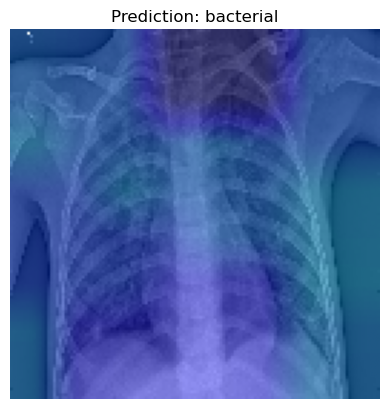

In [17]:
# Load the original image
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

# Resize the heatmap to match the image size
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# Convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed_img = heatmap * 0.4 + img

# Display the image
plt.imshow(superimposed_img / 255)
plt.title(f"Prediction: {targets[predicted_class]}")
plt.axis('off')
plt.show()